PROBLEM STATEMENT

The objective is to locate and recommend to the client which neighbourhood in New York City will be best choice to start a restaurant.

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

#from pandas import DataFrame

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install beautifulsoup4
from bs4 import BeautifulSoup

!conda install -c conda-forge folium
import folium # map rendering library

# Matplotlib and associated plotting modules
!pip install matplotlib


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

Neighborhoods using FourSquare API & New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [3]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID  # Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET  # Foursquare Secret, note there is a daily call quota it
    VERSION  # Foursquare API version
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
   
    # get all the data
    results = requests.get(url).json()
    My_venue_data=results["response"]['groups'][0]['items']
    My_venue_details=[]
    for row in My_venue_data:
        try:
            My_venue_id=row['venue']['id']
            My_venue_name=row['venue']['name']
            My_venue_category=row['venue']['categories'][0]['name']
            
            My_venue_details.append([My_venue_id,My_venue_name,My_venue_category])
            
        except KeyError:
            pass
                
            
    column_names=['ID','Name','Category']
    df = pd.DataFrame(My_venue_details,columns=column_names)
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

In [5]:
def get_My_venue_details(venue_id):
        
    CLIENT_ID # Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET  # Foursquare Secret, note there is a daily call quota it it
    VERSION  # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    My_venue_data=results['response']['venue']
    My_venue_details=[]
    try:
        My_venue_id=My_venue_data['id']
        My_venue_name=My_venue_data['name']
        My_venue_likes=My_venue_data['likes']['count']
        My_venue_rating=My_venue_data['rating']
        My_venue_tips=My_venue_data['tips']['count']
        My_venue_details.append([My_venue_id,My_venue_name,My_venue_likes,My_venue_rating,My_venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(My_venue_details,columns=column_names)
    return df

Define a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_My_new_york_data():
    
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    My_new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        My_borough = data['properties']['borough'] 
        My_neighborhood_name = data['properties']['name']
        
        My_neighborhood_latlon = data['geometry']['coordinates']
        My_neighborhood_lat = My_neighborhood_latlon[1]
        My_neighborhood_lon = My_neighborhood_latlon[0]
    
        My_new_york_data = My_new_york_data.append({'Borough': My_borough,
                                          'Neighborhood': My_neighborhood_name,
                                          'Latitude': My_neighborhood_lat,
                                          'Longitude': My_neighborhood_lon}, ignore_index=True)
    
    return My_new_york_data

In [7]:
# get new york data
My_new_york_data=get_My_new_york_data()

In [8]:
My_new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
My_new_york_data.shape

(306, 4)

Based on the dataset, there are a total of 306 different Neighborhoods in New York to select from

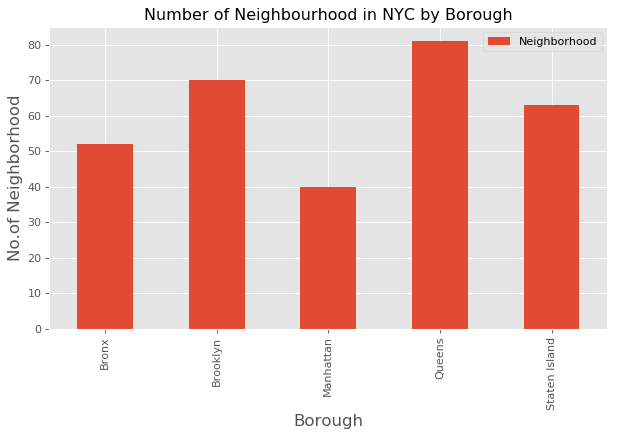

In [10]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
My_new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

Based on the data, Queens is the most densely populated borough in New York City with 80 neighborhoods

In [11]:
# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
My_indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in My_new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    My_indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(My_new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(My_indian_resturants)))
    for resturant_detail in My_indian_resturants.values.tolist():
        id, name , category=resturant_detail
        My_indian_rest_ny = My_indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:2
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [12]:
My_indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [13]:
My_indian_rest_ny.shape

(150, 4)

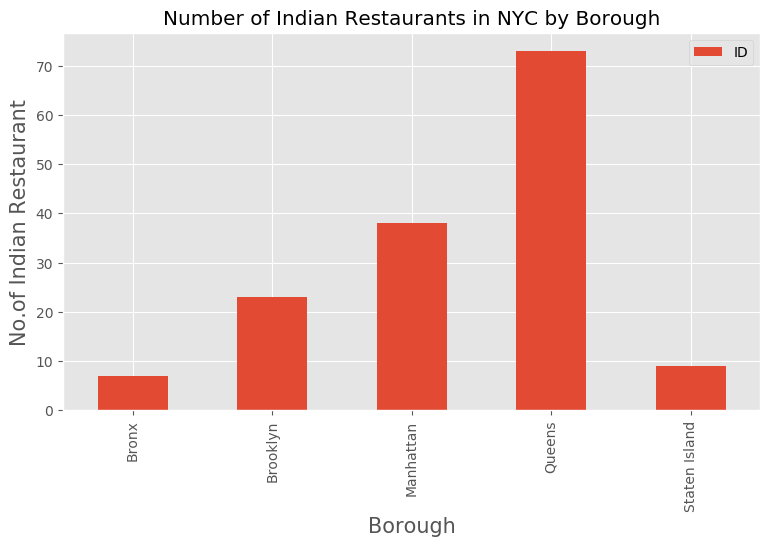

In [14]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
My_indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is noted that Queens has the highest number of Indian Restaurants.

In [15]:
My_indian_rest_ny[My_indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
106,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
107,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
108,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
112,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


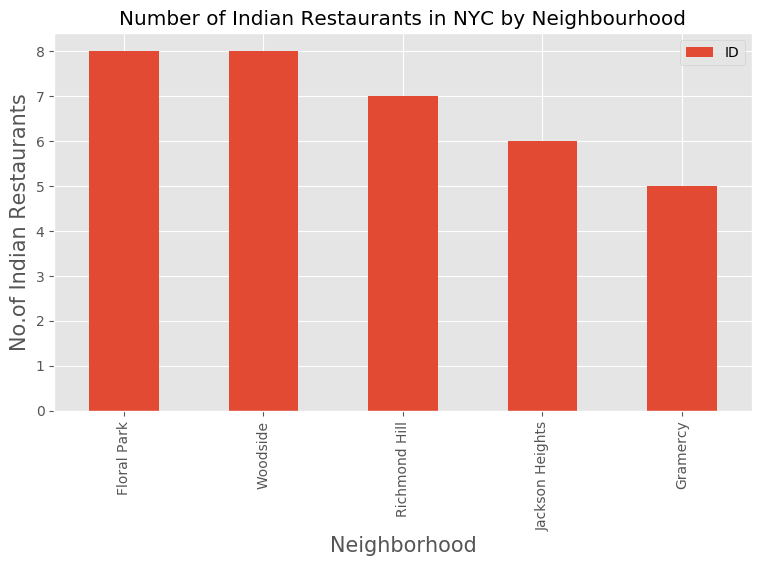

In [16]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
My_indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Floral Park And Woodside in Queens has the most Indian Resturants with a total count of 8.

In [17]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
My_indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in My_indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
My_indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in My_indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_My_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(My_indian_rest_ny),')','processed')
    My_indian_rest_stats_ny = My_indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.7    10
( 1 / 150 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 150 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 3 / 150 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 4 / 150 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 5 / 150 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 6 / 150 ) processed
                         ID       Name  Likes  Rat

No data available for id= 4afdcf29f964a520162b22e3
( 57 / 150 ) processed
No data available for id= 4b998d3ff964a520fc8235e3
( 58 / 150 ) processed
No data available for id= 4c7060e734443704ca0e245f
( 59 / 150 ) processed
No data available for id= 4b189424f964a52043d423e3
( 60 / 150 ) processed
No data available for id= 5da4fbf091a08400078be19d
( 61 / 150 ) processed
No data available for id= 4e334b7bb0fb17f64f81a8b2
( 62 / 150 ) processed
No data available for id= 49ebb18ff964a52016671fe3
( 63 / 150 ) processed
No data available for id= 3fd66200f964a52009f11ee3
( 64 / 150 ) processed
No data available for id= 527d9cbc498edf0db10bde6b
( 65 / 150 ) processed
No data available for id= 4b998d3ff964a520fc8235e3
( 66 / 150 ) processed
No data available for id= 4afdcf29f964a520162b22e3
( 67 / 150 ) processed
No data available for id= 5da4fbf091a08400078be19d
( 68 / 150 ) processed
No data available for id= 3fd66200f964a52009f11ee3
( 69 / 150 ) processed
No data available for id= 49ebb18ff964

In [45]:
My_indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [18]:
My_indian_rest_stats_ny.shape

(150, 7)

In [19]:
My_indian_rest_ny.shape

(150, 4)

In [20]:
My_indian_rest_stats_ny.to_csv('My_indian_rest_stats_ny.csv', index=False)

In [21]:
My_indian_rest_stats_ny_csv=pd.read_csv('My_indian_rest_stats_ny.csv')

In [22]:
My_indian_rest_stats_ny_csv.shape

(150, 7)

In [23]:
My_indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Parkchester,0,0,0,0.0,0
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3


In [24]:
My_indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
Borough         150 non-null object
Neighborhood    150 non-null object
ID              150 non-null object
Name            150 non-null object
Likes           150 non-null object
Rating          150 non-null float64
Tips            150 non-null object
dtypes: float64(1), object(6)
memory usage: 8.3+ KB


In [25]:
My_indian_rest_stats_ny['Likes']=My_indian_rest_stats_ny['Likes'].astype('float64')

In [26]:
My_indian_rest_stats_ny['Tips']=My_indian_rest_stats_ny['Tips'].astype('float64')

In [27]:
My_indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
Borough         150 non-null object
Neighborhood    150 non-null object
ID              150 non-null object
Name            150 non-null object
Likes           150 non-null float64
Rating          150 non-null float64
Tips            150 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.3+ KB


In [28]:
# Restaurants with maximum Likes
My_indian_rest_stats_ny.iloc[My_indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               9.1
Tips                                 148
Name: 42, dtype: object

In [29]:
# Restaurants with maximum Rating
My_indian_rest_stats_ny.iloc[My_indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               9.1
Tips                                 148
Name: 42, dtype: object

In [30]:
# Restaurants with maximum Tips
My_indian_rest_stats_ny.iloc[My_indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                425
Rating                               8.7
Tips                                 161
Name: 49, dtype: object

In [31]:
My_ny_neighborhood_stats=My_indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
My_ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

List of Top 10 neighborhoods which are in their order of average rating of Indian cuisine restaurants

In [32]:
My_ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
69,Tribeca,9.100000
32,Greenwich Village,8.900000
13,Clinton Hill,8.800000
26,Fort Greene,8.800000
75,West Village,8.733333
11,Chelsea,8.700000
46,Murray Hill,8.700000
20,East Village,8.600000
73,Upper West Side,8.550000
62,South Side,8.500000


Boroughs sorted with high average rating of Indian cuisine restaurants in New York city

In [33]:
My_ny_borough_stats=My_indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
My_ny_borough_stats.columns=['Borough','Average Rating']

In [34]:
My_ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,6.443478
2,Manhattan,5.450000
0,Bronx,4.700000
3,Queens,0.000000
4,Staten Island,0.000000


Bar chart visualizing the restaurants with average rating based on Boroughs

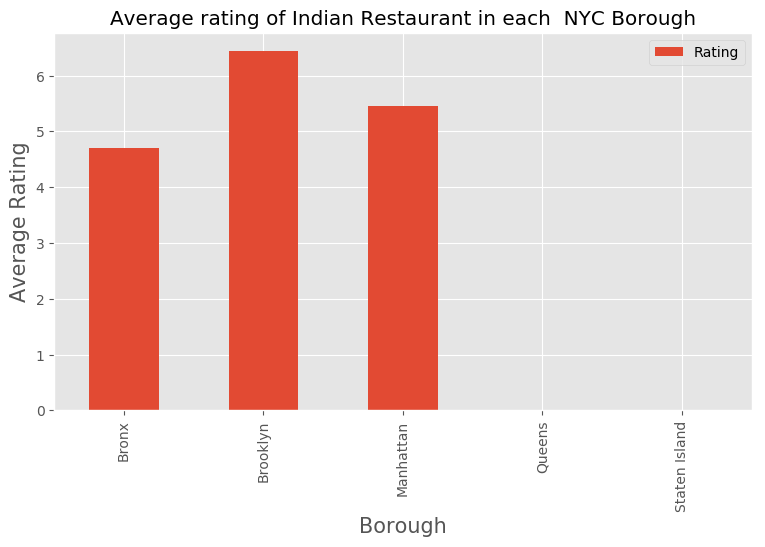

In [35]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
My_indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest average rating for Indian Restaurants.

All the neighborhoods with average rating greater or equal 8.0 to be visualized on map

In [36]:
My_ny_neighborhood_stats=My_ny_neighborhood_stats[My_ny_neighborhood_stats['Average Rating']>=8.0]

In [37]:
My_ny_neighborhood_stats

,Neighborhood,Average Rating
10,Central Harlem,8.050000
11,Chelsea,8.700000
13,Clinton Hill,8.800000
18,East Flatbush,8.000000
20,East Village,8.600000
26,Fort Greene,8.800000
32,Greenwich Village,8.900000
43,Manhattan Valley,8.100000
45,Morningside Heights,8.000000
46,Murray Hill,8.700000


In [38]:
My_ny_neighborhood_stats=pd.merge(My_ny_neighborhood_stats,My_new_york_data, on='Neighborhood')

In [39]:
My_ny_neighborhood_stats=My_ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [40]:
My_ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
16,Manhattan,Tribeca,40.721522,-74.010683,9.100000
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.900000
3,Brooklyn,Clinton Hill,40.693229,-73.967843,8.800000
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.800000
19,Manhattan,West Village,40.734434,-74.006180,8.733333
10,Manhattan,Murray Hill,40.748303,-73.978332,8.700000
2,Staten Island,Chelsea,40.594726,-74.189560,8.700000
1,Manhattan,Chelsea,40.744035,-74.003116,8.700000
11,Queens,Murray Hill,40.764126,-73.812763,8.700000
5,Manhattan,East Village,40.727847,-73.982226,8.600000


In [41]:
# create map and display it
My_ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [42]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in My_ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [43]:
My_ny_neighborhood_stats['Label']=My_ny_neighborhood_stats['Neighborhood']+', '+My_ny_neighborhood_stats['Borough']+'('+My_ny_neighborhood_stats['Average Rating'].map(str)+')'

Best neighbourhoods in New York that has highest average rating for Indian Restaurants.

In [44]:
# add pop-up text to each marker on the map
for lat, lng, label in My_ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(My_ny_map)        
# add incidents to map
My_ny_map.add_child(incidents)
# Make this Notebook Trusted to load ma

Findings

1. Clinton Hill, Fort Greene in Brooklyn are some of the best neighborhoods for Indian cuisine.
2. Staten Island and Queens has the lowest rated Indian Resturants in NYC.
3. Brooklyn is the best place to stay if you prefer Indian Cuisine.

Recommendation

Clinton Hill or Fort Greene in Brooklyn would be the best choice to start a restaurant given that

1. it is the First most populous urban area in New York City (NYC).
2. it has a population density of 13,957 people per square km.
3. it has some of the top rated Indian restaurants located in that area
4. It has the Fourth highest Asian ethnic minority population in NYC.